In [1]:
import os
import pandas as pd
import numpy as np
import datetime as dt
from sklearn import linear_model
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from fbprophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')




In [2]:
train_data = pd.read_csv("Train.csv")
test_data = pd.read_csv("Test.csv")

In [3]:
train_data.head()

,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2


In [4]:
test_data.head()

,ID,Datetime
0,18288,26-09-2014 00:00
1,18289,26-09-2014 01:00
2,18290,26-09-2014 02:00
3,18291,26-09-2014 03:00
4,18292,26-09-2014 04:00


In [5]:
train_data["data"]="train"
test_data["data"]="test"
data=pd.concat([train_data,test_data])
data = data.reset_index().drop(columns="index")
data['Datetime'] = pd.to_datetime(data['Datetime'],format = '%d-%m-%Y %H:%M')

In [6]:
data.head()

,ID,Datetime,Count,data
0,0,2012-08-25 00:00:00,8.0,train
1,1,2012-08-25 01:00:00,2.0,train
2,2,2012-08-25 02:00:00,6.0,train
3,3,2012-08-25 03:00:00,2.0,train
4,4,2012-08-25 04:00:00,2.0,train


In [7]:
data.columns

Index(['ID', 'Datetime', 'Count', 'data'], dtype='object')

In [22]:
def Fbprophet(data):
    size = np.sum(data['data']=='train')
    train_data = data[data["data"]=="train"]
    test_data = data[data["data"]=="test"]
    inter_df = train_data[['ds','y']]
    m = Prophet(seasonality_mode='multiplicative',changepoint_prior_scale=0.01)
    m.fit(inter_df)
    y_train=m.predict(train_data[['ds']])
    y_train_pred = y_train['yhat']
    print("RMSE : ",np.sqrt(mean_squared_error(train_data['y'],y_train_pred)))
    print(test_data.columns)
    future = m.make_future_dataframe(periods=5112, freq='H')
    forecast = m.predict(future)
    fcst = forecast['yhat']
    #plt.plot(train_data.ID, train_data.y)
    #plt.plot(test_data.ID, forecast["yhat"])
    plt.plot( forecast["yhat"])
    print(type(fcst))
    test_data = test_data.reset_index().drop(columns="index")
    df_fcst=fcst.tail(5112).to_frame().reset_index().drop(columns="index")
    print(df_fcst.shape)
    print(df_fcst.columns)
    #print("test_data df",df_fcst["yhat"])   
    submit = pd.concat([test_data[["ID"]], df_fcst],  axis = 1)
    print(submit)
    return submit


RMSE :  48.89896982705825
Index(['ID', 'ds', 'data', 'y'], dtype='object')
<class 'pandas.core.series.Series'>
(5112, 1)
Index(['yhat'], dtype='object')
         ID        yhat
0     18288  566.956767
1     18289  490.701265
2     18290  414.430841
3     18291  356.687577
4     18292  321.746481
...     ...         ...
5107  23395  914.410226
5108  23396  906.436670
5109  23397  904.954611
5110  23398  903.667444
5111  23399  874.278254

[5112 rows x 2 columns]


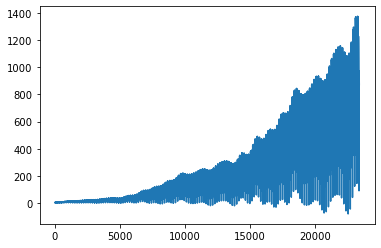

In [23]:
required_cols = [col for col in data.columns if col not in ['ID','Datetime', 'data']]


Result=pd.DataFrame()

for model in [Fbprophet]:
    for i in required_cols:
        data['Datetime'] = pd.to_datetime(data['Datetime'])
        to_func = data[['ID', 'Datetime',  'data', i]]
        to_func.columns=['ID', 'Datetime', 'data', 'Count']
        if model == Fbprophet:
            to_func.columns=["ID","ds","data", "y"]
            Result_inter = model(to_func[['ID','ds','data', 'y']])
            Result_inter.name = model.__name__ + "_" +  i
            Result_inter.index = range(len(Result_inter))
            
Result_inter.to_csv('Forecast_fbProphet.csv')

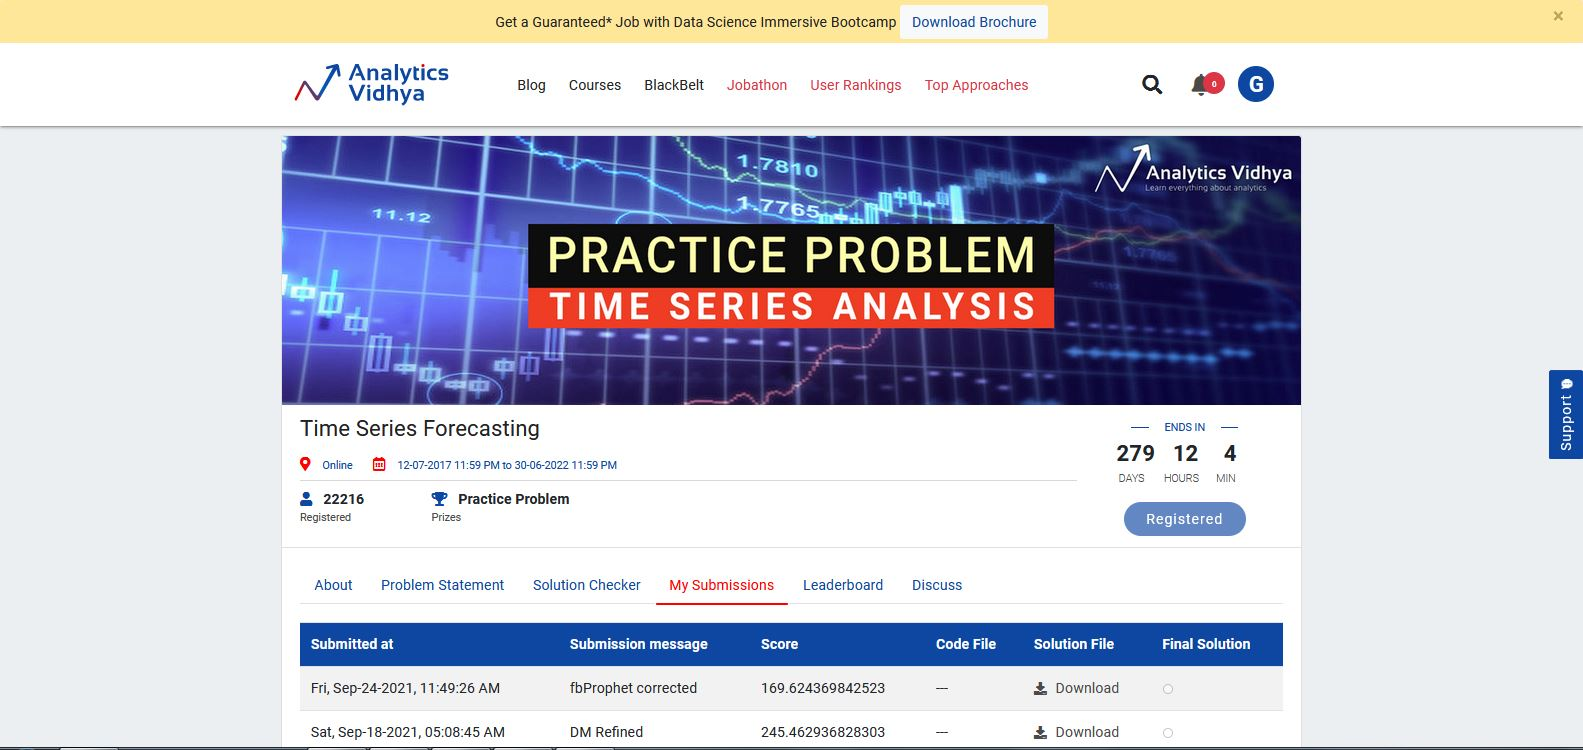

In [25]:
from IPython.display import Image
Image(filename='Score.JPG')